# EMBED Dataset Filtering

This notebook contains guidance on filtering EMBED by the following features:
- [Patient Race/Ethnicity](#section_1)
- [Patient Age](#section_2)
- [Breast Density](#section_3)
- [Invasive vs Non-Invasive Cancers](#section_4)
- [BIRADS](#section_5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import tableone
from tqdm import tqdm
import os
import random

In [2]:
def dataframe_stats(df, title: str or None = None):
    if title is not None:
        print(f"\n{title}")
        
    num_patients = df.empi_anon.nunique()
    num_exams = df.acc_anon.nunique()
    
    print(f"Patients: {num_patients}")
    print(f"Exams: {num_exams}")
    
    if 'png_path' in df.columns:
        print(f"Images: {len(df)}")
        
def plot_feature_density(feature, depth: int = 1, cmap: str = 'viridis'):
    # get colormap object
    cm = plt.get_cmap(cmap)
    
    # create the density plot
    axis = feature.plot.density(
        xlim=(feature.min(), feature.max()), 
        color=cm(0.0)
    )

    # get mean and standard deviation for age
    var_mean = feature.mean()
    var_std = feature.std()

    line = axis.get_lines()[0]

    # extract x and y data from the line object
    x = line.get_xdata()
    y = line.get_ydata()
    
    # plot mean
    axis.axvline(var_mean, color=cm(1.0), linestyle='--', label='Mean')
    
    # iterate over std depth levels
    for i in range(depth, 0, -1):
        # get bounds of std interval
        sigma_min, sigma_max = var_mean-(i*var_std), var_mean+(i*var_std)
        
        # mask array between bounds
        array_mask = (x >= sigma_min) & (x <= sigma_max)
        
        # plot std interval
        sigma_value = 0.7 / i
        axis.fill_between(x, y, where=array_mask, color=cm(sigma_value), alpha=0.3, label=f'{i}σ')
        
    ax.legend()
        
    return axis

In [3]:
base_directory = "/data/beatrice/emory_datathon/embed_upload"
mag_path = base_directory + "/tables/embed_datathon_magview_reduced.csv"
meta_path = base_directory + "/tables/embed_datathon_metadata_reduced.csv"

# load clinical data from magview
mag_df = pd.read_csv(mag_path)
dataframe_stats(mag_df, 'magview:')

# load image metadata
meta_df = pd.read_csv(meta_path)
dataframe_stats(meta_df, 'metadata:')

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



magview:
Patients: 115883
Exams: 364733


/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)



metadata:
Patients: 115894
Exams: 364733
Images: 2403687


---
<a id="section_1"></a>
## Patient Race and Ethnicity

EMBED has two demographic variables containing the race and ethnicity of patients:
- ETHNICITY_DESC: This variable contains the self-identified race of the patient. The category 'Hispanic' is present, but this is unreliable and the 'Hispanic or Latino' label of ETHNICITY_GROUP_DESC should be used to index Hispanic patients instead.
- ETHNICITY_GROUP_DESC: This variable contains the self-identified ethnicity of the patient. It is less clean than ETHNICITY_DESC and will require processing for use in analysis.

In [8]:
categorical_cols = ['ETHNICITY_DESC', 'ETHNIC_GROUP_DESC']
tableone(mag_df, categorical_cols)

Missing        Overall
n                                                                                  408464
ETHNICITY_DESC, n (%)    African American or Black                    1016  180922 (44.4)
                         American Indian or Alaskan Native                      846 (0.2)
                         Asian                                                21365 (5.2)
                         Caucasian or White                                 171948 (42.2)
                         Hispanic                                                34 (0.0)
                         Multiple                                              1307 (0.3)
                         Native Hawaiian or Other Pacific Islander             3835 (0.9)
                         Not Recorded                                            32 (0.0)
                         Patient Declines                                        20 (0.0)
                         Unknown, Unavailable or Unreported                   27139 (6.7)
ETHNIC_GROUP_DESC, n (%) CD:1231368306                                1016        2 (0.0)
                         CD:1565395161                                           31 (0.0)
                         CD:1565528481                                            3 (0.0)
                         CD:1641210453                                           21 (0.0)
                         CD:1702624199                                            1 (0.0)
                         CD:1719092855                                           14 (0.0)
                         CD:1793397901                                            1 (0.0)
                         CD:1808060937                                            2 (0.0)
                         CD:1847885097                                            5 (0.0)
                         CD:1858666135                                           41 (0.0)
                         CD:1862937909                                            6 (0.0)
                         CD:1902530759                                            1 (0.0)
                         CD:2100170165                                            6 (0.0)
                         CD:2112660279                                            3 (0.0)
                         CD:2264735701                                            1 (0.0)
                         CD:2268368555                                            2 (0.0)
                         Hispanic or Latino                                   19933 (4.9)
                         Non-Hispanic or Latino                             328421 (80.6)
                         Non-Hispanic~Unknown                                   159 (0.0)
                         Not Recorded                                          4133 (1.0)
                         Unknown~Hispanic                                        55 (0.0)
                         Unknown~Non-Hispanic                                   331 (0.1)
                         Unreported, Unknown, Unavailable                    54276 (13.3)

### Code Patient Race

In [11]:
# create the 'patient_race' column and set the default value to 'Unknown'
mag_df.loc[:, 'patient_race'] = 'Unknown'

# code races for Black and white patients
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'African American or Black', 'patient_race'] = 'Black'
mag_df.loc[mag_df['ETHNICITY_DESC'] == 'Caucasian or White', 'patient_race'] = 'White'

# consolidate other patient race categories
other_race_categories = [
    'American Indian or Alaskan Native', 
    'Asian', 
    'Hispanic', 
    'Multiple', 
    'Native Hawaiian or Other Pacific Islander'
]
mag_df.loc[mag_df['ETHNICITY_DESC'].isin(other_race_categories), 'patient_race'] = 'Other'

In [12]:
tableone(mag_df, ['ETHNICITY_DESC'], groupby=['patient_race'])

Grouped by patient_race                                                                           
                                                                                Missing        Overall           Black         Other       Unknown           White
n                                                                                               408464          180922         27387         28207          171948
ETHNICITY_DESC, n (%) African American or Black                                    1016  180922 (44.4)  180922 (100.0)                                            
                      American Indian or Alaskan Native                                      846 (0.2)                     846 (3.1)                              
                      Asian                                                                21365 (5.2)                  21365 (78.0)                              
                      Caucasian or White                                                 171948 (42.2)                                              171948 (100.0)
                      Hispanic                                                                34 (0.0)                      34 (0.1)                              
                      Multiple                                                              1307 (0.3)                    1307 (4.8)                              
                      Native Hawaiian or Other Pacific Islander                             3835 (0.9)                   3835 (14.0)                              
                      Not Recorded                                                            32 (0.0)                                    32 (0.1)                
                      Patient Declines                                                        20 (0.0)                                    20 (0.1)                
                      Unknown, Unavailable or Unreported                                   27139 (6.7)                                27139 (99.8)

### Code Patient Ethnicity

In [4]:
# create the 'patient_ethnicity' column and set the default value to 'Unknown'
mag_df.loc[:, 'patient_ethnicity'] = 'Unknown'

# code hispanic or latino patient ethnicity categories
hispanic_categories = [
    'Hispanic or Latino', 
    'Unknown~Hispanic', 
]
mag_df.loc[mag_df['ETHNIC_GROUP_DESC'].isin(hispanic_categories), 'patient_ethnicity'] = 'Hispanic'

# code non-hispanic or latino patient ethnicity categories
non_hispanic_categories = [
    'Non-Hispanic or Latino', 
    'Non-Hispanic~Unknown', 
    'Unknown~Non-Hispanic', 
]
mag_df.loc[mag_df['ETHNIC_GROUP_DESC'].isin(non_hispanic_categories), 'patient_ethnicity'] = 'Not Hispanic'

In [8]:
tableone(mag_df, ['ETHNIC_GROUP_DESC'], groupby=['patient_ethnicity'])

/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


Grouped by patient_ethnicity                                                          
                                                                               Missing        Overall      Hispanic   Not Hispanic       Unknown
n                                                                                              408464         19988         328911         59565
ETHNIC_GROUP_DESC, n (%) Hispanic or Latino                                       1016    19933 (4.9)  19933 (99.7)                             
                         Unknown~Hispanic                                                    55 (0.0)      55 (0.3)                             
                         Non-Hispanic or Latino                                         328421 (80.6)                328421 (99.9)              
                         Non-Hispanic~Unknown                                               159 (0.0)                    159 (0.0)              
                         Unknown~Non-Hispanic                                               331 (0.1)                    331 (0.1)              
                         CD:1231368306                                                        2 (0.0)                                    2 (0.0)
                         CD:1565395161                                                       31 (0.0)                                   31 (0.1)
                         CD:1565528481                                                        3 (0.0)                                    3 (0.0)
                         CD:1641210453                                                       21 (0.0)                                   21 (0.0)
                         CD:1702624199                                                        1 (0.0)                                    1 (0.0)
                         CD:1719092855                                                       14 (0.0)                                   14 (0.0)
                         CD:1793397901                                                        1 (0.0)                                    1 (0.0)
                         CD:1808060937                                                        2 (0.0)                                    2 (0.0)
                         CD:1847885097                                                        5 (0.0)                                    5 (0.0)
                         CD:1858666135                                                       41 (0.0)                                   41 (0.1)
                         CD:1862937909                                                        6 (0.0)                                    6 (0.0)
                         CD:1902530759                                                        1 (0.0)                                    1 (0.0)
                         CD:2100170165                                                        6 (0.0)                                    6 (0.0)
                         CD:2112660279                                                        3 (0.0)                                    3 (0.0)
                         CD:2264735701                                                        1 (0.0)                                    1 (0.0)
                         CD:2268368555                                                        2 (0.0)                                    2 (0.0)
                         Not Recorded                                                      4133 (1.0)                                 4133 (7.1)
                         Unreported, Unknown, Unavailable                                54276 (13.3)                               54276 (92.7)

In [9]:
tableone(mag_df, ['patient_race'], groupby=['patient_ethnicity'])

/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [
/home/jupyter-tbrow51/.conda/envs/tf2.13/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


Grouped by patient_ethnicity                                                         
                                                 Missing        Overall     Hispanic   Not Hispanic       Unknown
n                                                                408464        19988         328911         59565
patient_race, n (%) Black                              0  180922 (44.3)   1529 (7.6)  156122 (47.5)  23271 (39.1)
                    Other                                   27387 (6.7)  3408 (17.1)    21637 (6.6)    2342 (3.9)
                    Unknown                                 28207 (6.9)  8319 (41.6)     5072 (1.5)  14816 (24.9)
                    White                                 171948 (42.1)  6732 (33.7)  146080 (44.4)  19136 (32.1)

---
<a id="section_2"></a>
## Patient Age

In [47]:
mag_df['age_at_study'].describe()

count    407448.000000
mean         58.520519
std          12.065398
min          15.504767
25%          48.925714
50%          58.155883
75%          67.538690
max          89.000000
Name: age_at_study, dtype: float64

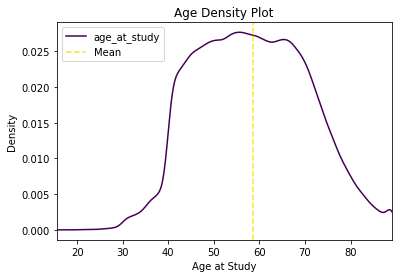

In [163]:
ax = plot_feature_density(mag_df['age_at_study'], depth=0, cmap='viridis')

# Add legend and title
ax.set_title('Age Density Plot')
ax.set_xlabel('Age at Study')
ax.legend()

plt.show()

In [73]:
# Convert the continuous age into a categorical variable
# find minimum age and its offset from the nearest multiple of 10
min_age = mag_df['age_at_study'].min()
min_age_offset = min_age % 10

# find maximum age and its offset from the nearest multiple of 10
max_age = mag_df['age_at_study'].max()
max_age_offset = 10 - (max_age % 10)

# create variable bins and bin labels
bins = [i for i in range(int(min_age - min_age_offset), int(max_age + max_age_offset + 1), 10)]
labels = [f"{i}-{i+10}" for i in bins[:-1]]

# create new 'age_bins' column and split 'age_at_study' into bins
mag_df['age_bins'] = pd.cut(mag_df['age_at_study'], bins=bins, labels=labels, right=False)

In [76]:
# inspect new bins
tableone(mag_df, ['age_at_study'], groupby=['age_bins'])

Grouped by age_bins                                                                                                             
                                     Missing      Overall       10-20       20-30       30-40       40-50       50-60       60-70       70-80       80-90
n                                                  408464          10         648       14343       98386      110822      106201       61082       15956
age_at_study, mean (SD)                 1016  58.5 (12.1)  18.4 (1.3)  27.4 (2.3)  36.2 (2.7)  45.2 (2.9)  55.0 (2.9)  64.9 (2.9)  74.1 (2.8)  84.0 (2.9)

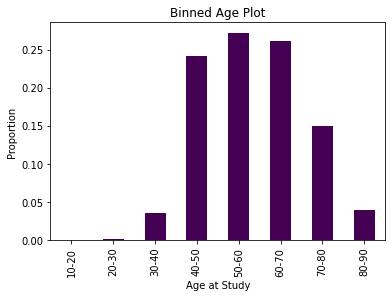

In [164]:
ax = mag_df['age_bins'].value_counts(normalize=True).sort_index().plot(kind='bar', cmap='viridis')

ax.set_xlabel('Age at Study')
ax.set_ylabel('Proportion')
ax.set_title('Binned Age Plot')

plt.show()

---
<a id="section_3"></a>
## Breast Density

Patient breast density is recorded in the 'tissueden' column in the BIRADS breast density format. This format is summarized in the table below.

| tissueden | Description | BIRADS |
| :-: | :-: | :-: |
| 1 | Breasts are almost entirely fat | A |
| 2 | Scattered fibroglandular densities | B |
| 3 | Heterogeneously dense | C |
| 4 | Extremely dense | D |
| 5 | Normal male** | N/a |

In [14]:
# inspect tissue density distribution
print(mag_df.tissueden.value_counts())

tableone(mag_df, ['tissueden'], groupby=['patient_race'])

3.0    175373
2.0    168269
1.0     38529
4.0     22603
5.0       709
Name: tissueden, dtype: int64


Grouped by patient_race                                                                       
                                     Missing        Overall         Black         Other       Unknown         White
n                                                    408464        180922         27387         28207        171948
tissueden, n (%) 1.0                    2981    38529 (9.5)  22910 (12.8)     805 (3.0)    1855 (6.6)   12959 (7.6)
                 2.0                          168269 (41.5)  81735 (45.5)   7196 (26.4)  10391 (37.1)  68947 (40.4)
                 3.0                          175373 (43.3)  67201 (37.4)  15860 (58.3)  13830 (49.4)  78482 (46.0)
                 4.0                            22603 (5.6)    7403 (4.1)   3348 (12.3)    1852 (6.6)   10000 (5.9)
                 5.0                              709 (0.2)     287 (0.2)      17 (0.1)      68 (0.2)     337 (0.2)

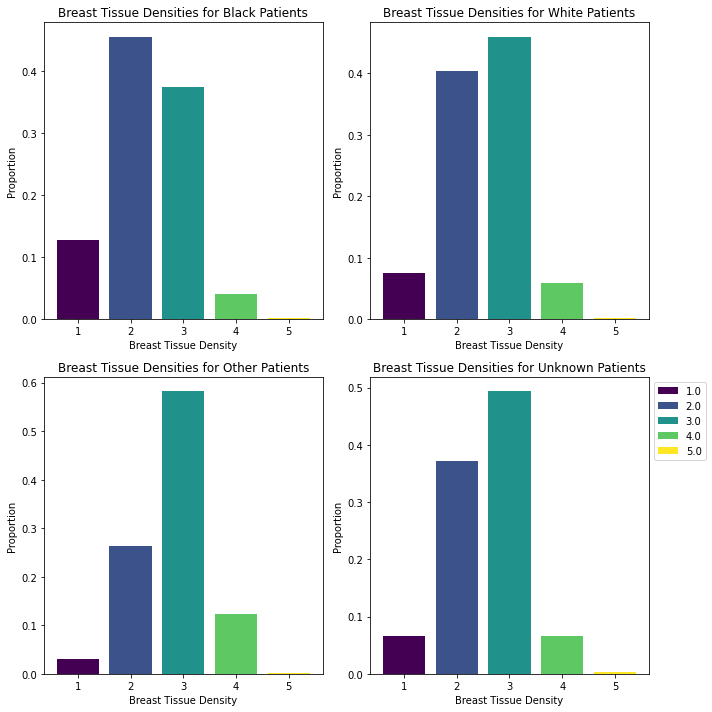

In [30]:
# list of unique values for patient race
race_descs = mag_df['patient_race'].dropna().unique()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.ravel()

colors = plt.cm.viridis(np.linspace(0.0, 1.0, mag_df['tissueden'].dropna().nunique()))
color_map = dict(zip(labels, colors))

bar_list = []

for i, race_desc in enumerate(race_descs):
    rel_densities = mag_df.loc[mag_df['patient_race'] == race_desc, 'tissueden'].dropna()
    
    labels, counts = np.unique(rel_densities, return_counts=True)
    
    bar_colors = [color_map[label] for label in labels]
    
    props = [c/len(rel_densities) for c in counts]
    
    curr_bar = axs[i].bar(labels, props, color=bar_colors)
    axs[i].set_title(f'Breast Tissue Densities for {race_desc} Patients')
    axs[i].set_ylabel('Proportion')
    axs[i].set_xlabel('Breast Tissue Density')
    
    bar_list.extend(curr_bar)
    
plt.legend(curr_bar, labels, loc="upper left", bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()

---
<a id="section_4"></a>
## Invasive vs Non-Invasive Cancers

Pathology findings are summarized in the feature 'path_severity' which contains the most-severe pathology finding from an exam. The table below summarizes the different categories. These scores are derived from the 'path1 - path10' columns. 'path_severity' has a large number of missing values as it's only populated for exams that received a biopsy.

| Path Severity | Classification |
| :-: | :-: |
| 0 | Invasive Cancer |
| 1 | Non-Invasive Cancer |
| 2 | High-Risk Lesion |
| 3 | Borderline Lesion |
| 4 | Benign Findings |
| 5 | Negative (Normal Breast Tissue) |
| 6 | Non-Breast Cancer |

In [24]:
mag_df['exam_type'] = 'Other'
mag_df.loc[mag_df['desc'].str.contains('screen', case=False), 'exam_type'] = 'Screening'
mag_df.loc[mag_df['desc'].str.contains('diag', case=False), 'exam_type'] = 'Diagnostic'
tableone(mag_df, ['path_severity'], groupby=['exam_type'])

Grouped by exam_type                                        
                                      Missing       Overall   Diagnostic    Screening
n                                                    408464       112277       296187
path_severity, n (%) 0.0               384574   5673 (23.7)  4182 (25.6)  1491 (19.8)
                     1.0                         2272 (9.5)   1478 (9.0)   794 (10.5)
                     2.0                        3551 (14.9)  2346 (14.3)  1205 (16.0)
                     3.0                          151 (0.6)    108 (0.7)     43 (0.6)
                     4.0                       11782 (49.3)  7852 (48.0)  3930 (52.2)
                     5.0                          461 (1.9)    391 (2.4)     70 (0.9)

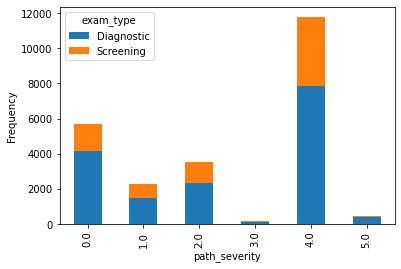

In [25]:
ax = mag_df.groupby(['path_severity', 'exam_type']).size().unstack().plot(kind='bar', stacked=True)
ax.set_ylabel('Frequency')

plt.show()

If a patient is assigned BIRADS 0 (further evaluation required), they will proceed to diagnostic mammogram with special views including compression and magnification paddles. They may also undergo concurrent ultrasound. In 2/3 of diagnostic mammograms, the finding disappears or is resolved as benign and the patient is a assigned BIRADS 1 or 2. In 1/3 of diagnostic mammograms, the finding persists and the patient is assigned a BIRADS score of 4 (suspicious) or 5 (highly suspicious) and will proceed to biopsy. Approximately 2/3 of biopsy results are benign and the patient will return to annual screening. Approximately 1/3 of biopsy results are malignant in which case they will go for further imaging (MRI to evaluate extent of disease) and/or surgical resection (lumpectomy or mastectomy). The patient will receive diagnostic mammograms for several years after this before returning to annual screening.

In the majority of cases, patients with pathologies will have their biopsy results linked back to their preceding screening exams. This isn't always the case though, and symptomatic patients do not receive screening mammography. Any patient with pain, discharge, or other symptoms go straight to diagnostic mammography where they will be evaluated, assigned a BIRADS score, and proceed to biopsy or further imaging if indicated. In these cases, patients may have a pathology result linked to a diagnostic exam that is NOT preceeded by a screening exam.

<div class="alert alert-block alert-info">
<b>Note:</b> It's generally better to train models on screening images. Diagnostic images regularly contain confounding factors like tags and paddles which can obscur the actual signal of interest. Models trained on criteria assigned during diagnostic exams should be trained on the preceding screening exams instead. A similar pipeline is shown in the BIRADS section.
</div>

---
<a id="section_5"></a>
## BIRADS

The [BI-RADS score](https://www.acr.org/-/media/ACR/Files/RADS/BI-RADS/Mammography-Reporting.pdf) score of the exam. This is assigned globally for an exam but repeated in each finding row. Screening exams may have BIRADS 0, 1, 2, or 3. Diagnostic exams may have BIRADS 4, 5, or 6. BIRADS 3 and 6 are slightly special causes and should be used with caution.

When patients receive a screening exam, they are assigned a BIRADS score of 0, 1, 2, or 3. BIRADS 1 and 2 are the most common assessments and indicate that the mammograms were negative or benign and the patient should return for standard yearly screenings. A BIRADS of 0 indicates that further evaluation is required and the patient should return for diagnostic mammograms to examine specific regions of tissue in the breast. In 2/3 of diagnostic mammograms, the finding disappears or is resolved as benign, and the patient is a assigned BIRADS 1 or 2. In 1/3 of diagnostic mammograms, the finding persists and the patient is assigned a BIRADS score of 4 (suspicious) or 5 (highly suspicious) and will proceed to biopsy. Biopsy proven cancers are assigned a BIRADS of 6.

| BIRADS | 'asses' | Assessment |
| :-: | :-: | :-: |
| BIRADS 0 | A | Additional evaluation |
| BIRADS 1 | N | Negative |
| BIRADS 2 | B | Benign |
| BIRADS 3 | P | Probably benign |
| BIRADS 4 | S | Suspicious |
| BIRADS 5 | M | Highly suggestive of malignancy |
| BIRADS 6 | K | Known biopsy proven |

In [26]:
tableone(mag_df, ['asses'], groupby=['exam_type'])

Grouped by exam_type                                            
                            Missing        Overall    Diagnostic      Screening
n                                           408464        112277         296187
asses, n (%) A                    0   57479 (14.1)    2780 (2.5)   54699 (18.5)
             B                        75969 (18.6)  43031 (38.3)   32938 (11.1)
             K                          2031 (0.5)    2018 (1.8)       13 (0.0)
             M                          1639 (0.4)    1634 (1.5)        5 (0.0)
             N                       228979 (56.1)  20619 (18.4)  208360 (70.3)
             P                         27444 (6.7)  27365 (24.4)       79 (0.0)
             S                         14817 (3.6)  14728 (13.1)       89 (0.0)
             X                           106 (0.0)     102 (0.1)        4 (0.0)

### Example Pipeline:

#### Positive (BIRADS 4 & 5)

In [14]:
# ensure our study date column is read as a datetime
mag_df['study_date_anon'] = pd.to_datetime(mag_df['study_date_anon'], errors='coerce', format= '%Y-%m-%d')

# get diagnostic exams with BIRADS 4/5
mag_diag_pos_df = mag_df[mag_df.asses.isin(['S','M']) & mag_df.desc.str.contains('diag', case=False)]

# get relevant columns to prepare for merge with screening exams
diag_cols = ['empi_anon', 'acc_anon', 'numfind', 'side', 'study_date_anon', 'asses']
mag_diag_pos_reduced_df = mag_diag_pos_df[diag_cols]

dataframe_stats(mag_diag_pos_reduced_df, 'mag_diag_pos_reduced_df:')

# rename columns to prepare for the merge
mag_diag_pos_reduced_df.columns = [
    'empi_anon', 
    'acc_anon_diag', 
    'diag_num', 
    'diag_side', 
    'diag_study_date', 
    'diag_asses'
]


mag_diag_pos_reduced_df:
Patients: 10622
Exams: 11638


In [15]:
# get dataframe of screening exams
mag_scr_df = mag_df[mag_df.desc.str.contains('screen', case=False)]

# left merge on empi_anon
mag_scr_pos_df = mag_diag_pos_reduced_df.merge(mag_scr_df, on='empi_anon', how='left')

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df:')


mag_scr_pos_df:
Patients: 10622
Exams: 24435


In [16]:
# keep screening exams with the same laterality as the subsequent diagnostic exams
mag_scr_pos_df = mag_scr_pos_df.loc[(mag_scr_pos_df.side == mag_scr_pos_df.diag_side)]

dataframe_stats(mag_scr_pos_df, 'mag_scr_pos_df: (after side filtering)')

# get time difference between diagnostic and screening exams
mag_scr_pos_df['study_date_diff'] = mag_scr_pos_df.diag_study_date - mag_scr_pos_df.study_date_anon

# keep only screening exams with a time diff less than +180 days
mag_scr_pos_rel_df = mag_scr_pos_df.loc[(mag_scr_pos_df.study_date_diff.dt.days >= 0) & 
                                        (mag_scr_pos_df.study_date_diff.dt.days <= 180)]

dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df: (after date filtering)')


mag_scr_pos_df: (after side filtering)
Patients: 6715
Exams: 10507

mag_scr_pos_rel_df: (after date filtering)
Patients: 5571
Exams: 5739


In [17]:
# define a list of columns from meta_df to retain
meta_cols = ['acc_anon', 'ImageLateralityFinal', 'png_path']

# filter the dataframe to only contain 2D images
meta_2d_df = meta_df[meta_df.FinalImageType == '2D']

# merge positive magview dataframe with metadata
meta_2d_scr_pos_df = mag_scr_pos_rel_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    left_on=['acc_anon', 'side'],
    right_on=['acc_anon', 'ImageLateralityFinal']
)
dataframe_stats(mag_scr_pos_rel_df, 'mag_scr_pos_rel_df')
dataframe_stats(meta_2d_scr_pos_df, 'meta_2d_scr_pos_df: (merged)')


mag_scr_pos_rel_df
Patients: 5571
Exams: 5739

meta_2d_scr_pos_df: (merged)
Patients: 5264
Exams: 5409
Images: 31766


#### Negative (BIRADS 1 & 2)

Since BIRADS 1 & 2 are assigned to both screening and diagnostic exams we'll need to retrieve them separately and concatenate the outputs.

In [18]:
# get diagnostic exams with BIRADS 1/2
mag_diag_neg_df = mag_df[mag_df.desc.str.contains('diag', case=False) & mag_df.asses.isin(['N','B'])]

dataframe_stats(mag_diag_neg_df, 'mag_diag_neg_df:')

# get relevant columns to prepare for merge with screening exams
diag_cols = ['empi_anon', 'acc_anon', 'numfind', 'side', 'study_date_anon', 'asses']
mag_diag_neg_reduced_df = mag_diag_neg_df[diag_cols]

# rename columns to prepare for the merge
mag_diag_neg_reduced_df.columns = [
    'empi_anon', 
    'acc_anon_diag', 
    'diag_num', 
    'diag_side', 
    'diag_study_date', 
    'diag_asses'
]

# merge negative diagnostic exams and screening exams
mag_diag_to_scr_neg_df = mag_diag_neg_reduced_df.merge(mag_scr_df, on='empi_anon', how='left')

dataframe_stats(mag_diag_to_scr_neg_df, 'mag_diag_to_scr_neg_df: (after merge on screening)')

# keep screening exams with the same laterality as the subsequent diagnostic exams
mag_diag_to_scr_neg_df = mag_diag_to_scr_neg_df.loc[(mag_diag_to_scr_neg_df.side == mag_diag_to_scr_neg_df.diag_side)]

dataframe_stats(mag_diag_to_scr_neg_df, 'mag_diag_to_scr_neg_df: (after side filtering)')

# get time difference between diagnostic and screening exams
mag_diag_to_scr_neg_df['study_date_diff'] = mag_diag_to_scr_neg_df.diag_study_date - mag_diag_to_scr_neg_df.study_date_anon

# keep only screening exams with a time diff less than +180 days
mag_diag_to_scr_neg_df = mag_diag_to_scr_neg_df.loc[
    (mag_diag_to_scr_neg_df.study_date_diff.dt.days >= 0) & 
    (mag_diag_to_scr_neg_df.study_date_diff.dt.days <= 180)
]

dataframe_stats(mag_diag_to_scr_neg_df, 'mag_diag_to_scr_neg_df: (after date filtering)')


mag_diag_neg_df:
Patients: 40581
Exams: 53469

mag_diag_to_scr_neg_df: (after merge on screening)
Patients: 40581
Exams: 98773

mag_diag_to_scr_neg_df: (after side filtering)
Patients: 23238
Exams: 36062

mag_diag_to_scr_neg_df: (after date filtering)
Patients: 15391
Exams: 16681


In [20]:
# get screening exams with BIRADS 1/2
mag_scr_neg_df = mag_df[mag_df.desc.str.contains('screen', case=False) & mag_df.asses.isin(['N','B'])]

dataframe_stats(mag_scr_neg_df, 'mag_scr_neg_df:')

# merge screening and diag-to-screen dataframes
mag_scr_neg_df = pd.concat([mag_scr_neg_df, mag_diag_to_scr_neg_df], axis=0).reset_index()

dataframe_stats(mag_scr_neg_df, 'mag_scr_neg_df: (after merge with diag-to-screen)')

# exclude patients that are included in the positive set
pos_empis = meta_2d_scr_pos_df.empi_anon.unique()
mag_scr_neg_rel_df = mag_scr_neg_df[~mag_scr_neg_df.empi_anon.isin(pos_empis)].reset_index()

dataframe_stats(mag_scr_neg_rel_df, 'mag_scr_neg_rel_df: (after empi exclusion)')

# merge meta_2d_df with negative screening exams in magview
meta_2d_scr_neg_df = mag_scr_neg_rel_df.merge(
    meta_2d_df[meta_cols], 
    how='inner', 
    on='acc_anon'
)

dataframe_stats(meta_2d_scr_neg_df, 'meta_2d_scr_neg_df: (after merge)')

# filter image/exam laterality
# we can't easily merge on side/ImageLateralityFinal like we have in 
# other cases since 'side' is undefined for many negative/benign exams
meta_2d_scr_neg_df = meta_2d_scr_neg_df[
    ~((meta_2d_scr_neg_df['side'] == 'L') & 
    (meta_2d_scr_neg_df['ImageLateralityFinal'] == 'R'))
]

meta_2d_scr_neg_df = meta_2d_scr_neg_df[
    ~((meta_2d_scr_neg_df['side'] == 'R') & 
    (meta_2d_scr_neg_df['ImageLateralityFinal'] == 'L'))
]

meta_2d_scr_neg_df = meta_2d_scr_neg_df.drop_duplicates(subset='png_path')

dataframe_stats(meta_2d_scr_neg_df, 'meta_2d_scr_neg_df: (after laterality filter)')


mag_scr_neg_df:
Patients: 87915
Exams: 238468

mag_scr_neg_df: (after merge with diag-to-screen)
Patients: 92011
Exams: 254311

mag_scr_neg_rel_df: (after empi exclusion)
Patients: 87907
Exams: 241697

meta_2d_scr_neg_df: (after merge)
Patients: 85887
Exams: 228263
Images: 1164104

meta_2d_scr_neg_df: (after laterality filter)
Patients: 85887
Exams: 228260
Images: 1057665


Our dataframes (meta_2d_scr_pos_df & meta_2d_scr_neg_df) are now ready for class balancing and model training!